## Importações e Configuração Inicial
 - AJUSTAR PARA BUSCAR INFORMAÇÕES DE PONTUAÇÕES MENSAIS

In [17]:
import cartolafc
import pandas as pd
from difflib import get_close_matches
from pathlib import Path
from bs4 import BeautifulSoup
import json, re
import time
import requests

pd.set_option('display.max_columns', 50)            # permite a visualização de 50 colunas do dataframe
pd.options.display.float_format = '{:.2f}'.format   # pandas: para todos os números aparecerem com duas casas decimais

# Cria uma instância da API
api = cartolafc.Api(attempts=5)

In [18]:
from bs4 import BeautifulSoup
from pathlib import Path
import json, re

# ajuste se precisar
HTML_PATH = Path("pagina_liga_classica.html")

# carrega html
html = HTML_PATH.read_text(encoding="utf-8", errors="ignore")
soup = BeautifulSoup(html, "html.parser")

# 1) principais seletores desta versão da página
seletores = [
    "div.info-time h3",              # novo layout (print do DevTools)
    # "a.button-container-card h3",    # h3 dentro do link do time
    # "div.card-row-info h3",          # variações
    # "section.container-lista-times h3",
    # "ranking-de-liga h3",
]

nomes = []
for sel in seletores:
    for el in soup.select(sel):
        t = el.get_text(strip=True)
        if t:
            nomes.append(t)

# 2) fallback: pegar o texto do link que aponta para #!/time/<id>
if not nomes:
    for a in soup.select("a[href*='#!/time/']"):
        t = a.get_text(" ", strip=True)
        if t:
            nomes.append(t)

# 3) fallback final: regex focada no bloco info-time -> <h3>...</h3>
if not nomes:
    for m in re.findall(r'class="info-time"[^>]*>.*?<h3[^>]*>(.*?)</h3>', html, flags=re.I|re.S):
        t = BeautifulSoup(m, "html.parser").get_text(strip=True)
        if t:
            nomes.append(t)

# dedup (ordem de aparição) + limpeza + ordenação alfabética
visto, times = set(), []
for n in nomes:
    n = re.sub(r"\s+", " ", n).strip()
    if n and n not in visto:
        visto.add(n)
        times.append(n)

times.sort(key=str.casefold)

print(f"{len(times)} times encontrados")
print(times[:10])  # amostra

# salva snippet JS ao lado do HTML
OUT_JS = HTML_PATH.with_name("participantesLiga_Classica.js")
OUT_JS.write_text(
    "window.participantesLiga = " + json.dumps(times, ensure_ascii=False, indent=2) + ";\n",
    encoding="utf-8"
)
print(f"Snippet salvo em: {OUT_JS}")


60 times encontrados
['A Lenda Super Vasco F.c', 'A Lenda Super Vascão f.c', 'Analove10 ITAQUI GRANDE!!', 'BordonFC', 'BORGES CLIMA FUT F.C', 'BORGES ITAQUI F.C.', 'C.A. Charru@', 'CALOMBO ITAQUI RS', 'cartola scheuer', 'clarinvalau fc']
Snippet salvo em: participantesLiga_Classica.js


In [19]:
# # 👉 ajuste aqui se precisar
# HTML_PATH = Path("pagina_liga_classica.html")  

# # carrega html
# soup = BeautifulSoup(HTML_PATH.read_text(encoding="utf-8", errors="ignore"), "html.parser")

# # coleta nomes (principal + fallback)
# nomes = [el.get_text(strip=True) for el in soup.select("p.nome-time")]
# if not nomes:
#     nomes = [(a.get("title") or a.get_text(strip=True)).strip()
#              for a in soup.select("a.link-perfil-time") if (a.get("title") or a.get_text(strip=True))]

# # dedup + ordena alfabético
# visto, times = set(), []
# for n in nomes:
#     if n and n not in visto:
#         visto.add(n); times.append(n)
# times.sort(key=str.casefold)

# print(f"{len(times)} times encontrados")
# print(times)

# # snippet JS ao lado do HTML
# OUT_JS = HTML_PATH.with_name("participantesLiga_Classica.js")
# OUT_JS.write_text("window.participantesLiga = " + json.dumps(times, ensure_ascii=False, indent=2) + ";\n", encoding="utf-8")
# print(f"Snippet salvo em: {OUT_JS}")


In [20]:
JS_PATH = Path("participantesLiga_Classica.js")  # ajuste o caminho se estiver em outra pasta

# extrai o array do snippet: window.participantesLiga = [ ... ];
m = re.search(r'window\.participantesLiga\s*=\s*(\[[\s\S]*?\])\s*;', JS_PATH.read_text(encoding="utf-8"))
if not m:
    raise ValueError(f"Não consegui achar a lista dentro de {JS_PATH}")

nomes_times = json.loads(m.group(1))

# (opcional) dedup + ordena
nomes_times = sorted(dict.fromkeys(nomes_times), key=str.casefold)

print(len(nomes_times), "times")
nomes_times[:10]

60 times


['A Lenda Super Vasco F.c',
 'A Lenda Super Vascão f.c',
 'Analove10 ITAQUI GRANDE!!',
 'BordonFC',
 'BORGES CLIMA FUT F.C',
 'BORGES ITAQUI F.C.',
 'C.A. Charru@',
 'CALOMBO ITAQUI RS',
 'cartola scheuer',
 'clarinvalau fc']

In [21]:

# nomes_times = ["Real SCI", "Gig@ntte", "PraiaBravaFC", "OlhaEleAiF.C!", "Gremiomaniasm", "Sport Clube PAIM", "PUXE FC", "RS Expressões da Arte", "ZIVI FC", "O clube do povo Itaqui/Rss",
#                "F.C. Rei Das Copas", "Rolo Compressor ZN", "Taura da Fronteira FCIII", "Eleis-Itaqui", "KING LEONN", "Laranjja Mecannica", "Fedato Futebol Clube", "Perronee F.C", "Pity10",
#                "pra sempre imortal fc", "RHANKA DENTY FC25", "TEAM LOPES 99", "pura bucha /botafogo", "cartola scheuer", "Analove10 ITAQUI GRANDE!!", "DM Studio",
#                "lsauer fc", "VASCO MARTINS FC", "KP JUV.", "BORGES ITAQUI F.C.", "Profit Soccer", "Tabajara de Inhaua FC2", "TIGRE LEON", "S.E.R. GRILLO", "seralex", "E.C. Bororé",
#                "Texas Club 2025", "MAFRA MARTINS FC", "BordonFC", "Tatols Beants F.C", "FIGUEIRA DA ILHA", "MauHumor F.C.", "A Lenda Super Vascão f.c", "TATITTA FC", "HS SPORTS F.C",
#                "FBC Colorado", "Dom Camillo68", "mercearia Estrela", "CosmoCity ZO", "clarinvalau fc", "Grêmio imortal 37", "SERGRILLO", "Super Vasco f.c", "A Lenda Super Vasco F.c", 
#                "Paulo Virgili FC", "CALOMBO ITAQUI RS", "Luis lemes inter", "emer jr fc", "Cril Futebol Club", "Santo Ângelo United", "Remo Santo Ângelo"]


# Dicionário para armazenar os IDs dos times
ids_times = {}

# Função para buscar o ID de um time pelo nome usando correspondência flexível
def buscar_id_time(nome_time):
    try:
        times = api.times(query=nome_time)
        nomes_api = [time.nome for time in times]
        nome_proximo = get_close_matches(nome_time, nomes_api, n=1, cutoff=0.6)
        if nome_proximo:
            for time in times:
                if time.nome == nome_proximo[0]:
                    return time.id
    except cartolafc.errors.CartolaFCError as e:
        print(f"Erro ao buscar ID para o time {nome_time}: {e}")
    return None

# Buscar os IDs dos times pelo nome
for nome in nomes_times:
    time_id = buscar_id_time(nome)
    if time_id:
        ids_times[nome] = time_id
    else:
        print(f"Não foi possível encontrar o ID para o time {nome}")

print(nomes_times)

['A Lenda Super Vasco F.c', 'A Lenda Super Vascão f.c', 'Analove10 ITAQUI GRANDE!!', 'BordonFC', 'BORGES CLIMA FUT F.C', 'BORGES ITAQUI F.C.', 'C.A. Charru@', 'CALOMBO ITAQUI RS', 'cartola scheuer', 'clarinvalau fc', 'CosmoCity ZO', 'DM Studio', 'Dom Camillo68', 'emer jr fc', 'FBC Colorado', 'FBC Colorado II', 'Fedato Futebol Clube', 'FIGUEIRA DA ILHA', 'Gig@ntte', 'Gremiomaniasm', 'HS SPORTS F.C', 'JV5 Tricolor Gaúcho', 'KING LEONN', 'KP JUV.', 'Laranjja Mecannica', 'lsauer fc', 'Luis lemes inter', 'MAFRA MARTINS FC', 'MauHumor F.C.', 'mercearia Estrela', 'Noah A 10', 'O clube do povo Itaqui/Rss', 'OlhaEleAiF.C!', 'Paulo Virgili FC', 'Perronee F.C', 'Pity10', 'pra sempre imortal fc', 'PraiaBravaFC', 'Profit Soccer', 'pura bucha /botafogo', 'PUXE FC', 'Real SCI', 'RHANKA DENTY FC25', 'Rolo Compressor ZN', 'RS Expressões da Arte', 'S.E.R. GRILLO', 'seralex', 'SERGRILLO', 'Sport Clube PAIM', 'Super Vasco f.c', 'SUPER VASCÃO F.C', 'Tabajara de Inhaua FC2', 'TATITTA FC', 'Tatols Beants F.C

In [22]:
# Gerar DataFrame com nome do time, ID e URL
df_urls = pd.DataFrame([
    {"Nome do Time": nome, "ID do Time": time_id, "Link do Time": f"https://cartola.globo.com/#!/time/{time_id}"}
    for nome, time_id in ids_times.items()
])

# Caminho e nome do arquivo Excel
caminho_excel = "links_times_cartola_liga_classica.xlsx"

# Salvar o DataFrame em Excel
df_urls.to_excel(caminho_excel, index=False)

print(f"✅ Arquivo salvo com sucesso: {caminho_excel}")


# Exibir como tabela
display(df_urls)


✅ Arquivo salvo com sucesso: links_times_cartola_liga_classica.xlsx


,Nome do Time,ID do Time,Link do Time
0,A Lenda Super Vasco F.c,117598,https://cartola.globo.com/#!/time/117598
1,A Lenda Super Vascão f.c,49355335,https://cartola.globo.com/#!/time/49355335
2,Analove10 ITAQUI GRANDE!!,44574236,https://cartola.globo.com/#!/time/44574236
3,BordonFC,2602301,https://cartola.globo.com/#!/time/2602301
4,BORGES CLIMA FUT F.C,49852616,https://cartola.globo.com/#!/time/49852616
5,BORGES ITAQUI F.C.,3914981,https://cartola.globo.com/#!/time/3914981
6,C.A. Charru@,25748736,https://cartola.globo.com/#!/time/25748736
7,CALOMBO ITAQUI RS,8707471,https://cartola.globo.com/#!/time/8707471
8,cartola scheuer,3851966,https://cartola.globo.com/#!/time/3851966
9,clarinvalau fc,8319052,https://cartola.globo.com/#!/time/8319052


In [23]:
# Obter a rodada atual do mercado
rodada_atual = api.mercado().rodada_atual

print("Rodada Atual:", rodada_atual)

Rodada Atual: 21


## Obter Pontuações da Rodada

In [24]:
# ===============================
#  CARTOLA FC - CLASSIFICAÇÃO COM PARCIAIS DA RODADA
# ===============================
import time
import json
import requests
import pandas as pd

# Se usar exceptions específicas da lib:
try:
    import cartolafc
    from cartolafc import CartolaFCError
except Exception:
    CartolaFCError = Exception  # fallback

# -------------------------------
# CONFIG
# -------------------------------
CAP_MULT = 1.5        # multiplicador do capitão (Cartola = dobra pontos)
PER_REQ_SLEEP = 0.9   # pausa entre requests (evitar 429/403)
MAX_RETRIES = 3       # tentativas por requisição

# Sessão HTTP
sess = requests.Session()
sess.headers.update({
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json, text/plain, */*",
})

# -------------------------------
# HELPERS HTTP / API
# -------------------------------
def http_status_e_rodada():
    r = sess.get("https://api.cartola.globo.com/mercado/status", timeout=20)
    r.raise_for_status()
    data = r.json()
    return int(data.get("status_mercado", 0)), int(data.get("rodada_atual", 0))

def get_parciais():
    r = sess.get("https://api.cartola.globo.com/atletas/pontuados", timeout=30)
    r.raise_for_status()
    data = r.json()
    return data.get("atletas", {})

def get_escalacao_por_rodada_http_dbg(time_id: int, rodada: int, max_retries=MAX_RETRIES):
    """
    Busca escalação travada na rodada; se não vier, cai para 'última escalação conhecida'.
    Retorna: (atletas:list, capitao_id:int|None, url_usada:str|None, http_status:int|None, motivo:str|None)
    """
    urls = [
        f"https://api.cartola.globo.com/time/id/{time_id}/{rodada}",
        f"https://api.cartola.globo.com/time/id/{time_id}",
    ]
    last_err = None
    for url in urls:
        wait = 0.7
        for attempt in range(1, max_retries + 1):
            try:
                r = sess.get(url, timeout=30)
                status = r.status_code
                if status == 200:
                    d = r.json()
                    atletas = d.get("atletas") or []
                    capitao_id = d.get("capitao_id")
                    if atletas:
                        return atletas, capitao_id, url, status, None  # ok
                    else:
                        return [], d.get("capitao_id"), url, status, "sem_atletas"
                elif status in (403, 429, 503):
                    last_err = f"status={status}"
                    time.sleep(wait); wait *= 1.8
                    continue
                else:
                    last_err = f"status={status}"
                    break
            except Exception as e:
                last_err = f"exc:{type(e).__name__}"
                time.sleep(wait); wait *= 1.8
        # tenta próxima URL (fallback)
    return [], None, None, None, last_err  # falhou nas duas

# -------------------------------
# 1) RODADA ATUAL E DF BASE
# -------------------------------
try:
    rodada_atual = api.mercado().rodada_atual
except CartolaFCError:
    rodada_atual = 1

def campeonato_comecou(ids_times: dict) -> bool:
    # considera "começou" se já existe pontuação na rodada 1 para algum time
    for time_id in ids_times.values():
        try:
            p = api.time(time_id=int(time_id), rodada=1).ultima_pontuacao
            if p is not None:
                return True
        except Exception:
            continue
    return False

if not campeonato_comecou(ids_times):
    print("📌 O campeonato ainda não começou. Criando estrutura com placeholders.")
    total_rodadas = 38
    df_pontuacoes = pd.DataFrame(index=ids_times.keys(),
                                 columns=[f'Rodada {i}' for i in range(1, total_rodadas + 1)])
    df_pontuacoes[:] = 0.0
else:
    def obter_pontuacao_por_rodada(time_id: int, rodada_atual_api: int) -> dict:
        # Só rodadas ENCERRADAS: 1 .. (rodada_atual_api - 1)
        pontuacoes = {}
        fim_exclusivo = max(1, int(rodada_atual_api))
        for rodada in range(1, fim_exclusivo):
            try:
                t = api.time(time_id=int(time_id), rodada=rodada)
                pontuacoes[rodada] = t.ultima_pontuacao
            except Exception:
                pontuacoes[rodada] = None
        return pontuacoes

    df_pontuacoes = pd.DataFrame()
    for nome, time_id in ids_times.items():
        pontuacoes = obter_pontuacao_por_rodada(int(time_id), rodada_atual)
        df_pontuacoes[nome] = pd.Series(pontuacoes)

    df_pontuacoes = df_pontuacoes.transpose()
    if rodada_atual > 1:
        df_pontuacoes.columns = [f'Rodada {i}' for i in range(1, rodada_atual)]
    df_pontuacoes = df_pontuacoes.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# -------------------------------
# 2) APLICA PARCIAIS (SOMENTE SE status==2)
# -------------------------------
status_http, rodada_http = http_status_e_rodada()
rodada_parcial = int(rodada_http) if status_http == 2 else None

print(
    f"Status HTTP={status_http} | rodada_http={rodada_http} | "
    f"rodada_api={rodada_atual} | rodada_parcial={rodada_parcial}"
)

if rodada_parcial is not None:
    col_parcial = f"Rodada {rodada_parcial}"
    if col_parcial not in df_pontuacoes.columns:
        df_pontuacoes[col_parcial] = 0.0  # cria coluna da rodada em andamento

    # remove marcador para evitar conflito
    if "Lider_Rodada" in df_pontuacoes.index:
        df_pontuacoes = df_pontuacoes.drop(index="Lider_Rodada", errors="ignore")

    print("🟡 Rodada em andamento — consultando parciais…")
    parciais_map = get_parciais()
    if not parciais_map:
        print("⚠️ Endpoint de parciais retornou vazio agora. Mantendo valores anteriores.")
    else:
        atualizados, relatorio = 0, []
        for nome_time, time_id in ids_times.items():
            try:
                time_id = int(time_id)
                atletas, capitao_id, url_usada, http_st, motivo = \
                    get_escalacao_por_rodada_http_dbg(time_id, rodada_parcial)

                # fallback via lib quando vier sem atletas
                if not atletas and (motivo in ("sem_atletas", "sem_escalacao", None)):
                    try:
                        t = api.time(time_id=time_id, rodada=rodada_parcial)
                        atletas = [{"atleta_id": a.atleta_id} for a in (t.atletas or [])]
                        if not capitao_id:
                            capitao_id = getattr(t, "capitao_id", None)
                        http_st = http_st or 200
                    except Exception:
                        pass

                total, matched = 0.0, 0
                for a in (atletas or []):
                    aid = str(a.get("atleta_id"))
                    if aid in parciais_map:
                        p = float(parciais_map[aid].get("pontuacao", 0) or 0)
                        if capitao_id and a.get("atleta_id") == capitao_id:
                            p *= CAP_MULT
                        total += p; matched += 1

                df_pontuacoes.loc[nome_time, col_parcial] = round(total, 2)
                atualizados += 1
                relatorio.append((nome_time, http_st or 200, len(atletas or []), matched, round(total, 2), "ok"))
                time.sleep(PER_REQ_SLEEP)
            except Exception as e:
                relatorio.append((nome_time, None, 0, 0, 0.0, f"erro:{type(e).__name__}"))

        print(f"✅ Times atualizados: {atualizados} / {len(ids_times)} na coluna '{col_parcial}'")
        for row in relatorio[:12]:
            nm, st, n_atl, n_ok, tot, mot = row
            print(f" • {nm:25} | HTTP={st} | atletas={n_atl:2d} | com_parcial={n_ok:2d} | total={tot:6.2f} | {mot}")
else:
    print("ℹ️ Sem parciais (status != 2). Nenhuma rodada em andamento.")

# Recalcula marcador de líder por rodada (opcional, só se houver algum > 0)
try:
    df_num = df_pontuacoes.apply(pd.to_numeric, errors="coerce")
    if (df_num.sum(numeric_only=True).sum() or 0) != 0:
        lider_rodada = df_num.idxmax()
        df_pontuacoes.loc["Lider_Rodada"] = lider_rodada
except Exception as e:
    print("⚠️ Não foi possível recalcular 'Lider_Rodada':", e)

# Normaliza tipos
df_pontuacoes = df_pontuacoes.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# -------------------------------
# 3) SEGMENTAÇÃO POR TURNOS E MESES
# -------------------------------
rodadas_por_mes = {
    "Agosto":   [18, 19, 20, 21, 22],
    "Setembro": [23, 24, 25],
    "Outubro":  [26, 27, 28],
    "Novembro": [29, 30, 31, 32],
    "Dezembro": [33, 34, 35, 36, 37, 38],
}
rodadas_segundo_turno = list(range(20, 39))

def somar_pontuacoes(df, rodadas):
    colunas = [f'Rodada {i}' for i in rodadas if f'Rodada {i}' in df.columns]
    return df[colunas].drop(index='Lider_Rodada', errors='ignore').sum(axis=1).sort_values(ascending=False)

df_turno_2 = df_pontuacoes[[f'Rodada {i}' for i in rodadas_segundo_turno if f'Rodada {i}' in df_pontuacoes.columns]]
df_soma_turno_2 = somar_pontuacoes(df_pontuacoes, rodadas_segundo_turno)
df_soma_mensal = {mes: somar_pontuacoes(df_pontuacoes, rodadas) for mes, rodadas in rodadas_por_mes.items()}

# -------------------------------
# 4) SALVAR EXCEL E JS
# -------------------------------
with pd.ExcelWriter("Pontuacoes_Liga_Classica_Completa.xlsx") as writer:
    df_pontuacoes.to_excel(writer, sheet_name="Geral")
    df_turno_2.to_excel(writer, sheet_name="Turno 2")
    pd.DataFrame(df_soma_turno_2).to_excel(writer, sheet_name="Classif Turno 2")
    for mes, serie in df_soma_mensal.items():
        pd.DataFrame(serie).to_excel(writer, sheet_name=f"Mês - {mes}")

print("✅ Excel: Pontuacoes_Liga_Classica_Completa.xlsx salvo.")

# JS
df_dict_geral = df_pontuacoes.drop(index='Lider_Rodada', errors='ignore').fillna(0).to_dict(orient="index")
df_js = {
    "geral": df_dict_geral,
    "turnos": {"turno_2": df_soma_turno_2.to_dict()},
    "meses": {mes: serie.to_dict() for mes, serie in df_soma_mensal.items()}
}
js_path = "Pontuacoes_Liga_Classica.js"
with open(js_path, "w", encoding="utf-8") as f:
    f.write(f"const classificacaoLigaClassica = {json.dumps(df_js, indent=2, ensure_ascii=False)};")
    # Meta (opcional) para o front saber se há parcial e qual rodada é:
    meta = {"status_http": int(status_http), "rodada_parcial": (int(rodada_parcial) if rodada_parcial is not None else None)}
    f.write("\nwindow.ligaClassicaMeta = " + json.dumps(meta) + ";")

print(f"✅ JS: {js_path} salvo.")


Status HTTP=1 | rodada_http=21 | rodada_api=21 | rodada_parcial=None
ℹ️ Sem parciais (status != 2). Nenhuma rodada em andamento.
✅ Excel: Pontuacoes_Liga_Classica_Completa.xlsx salvo.
✅ JS: Pontuacoes_Liga_Classica.js salvo.


In [25]:
# # ===============================
# #  CARTOLA FC - CLASSIFICAÇÃO COM PARCIAIS DA RODADA
# # ===============================
# import time
# import json
# import requests
# import pandas as pd
# from math import ceil

# # Se usar exceptions específicas da lib:
# try:
#     import cartolafc
#     from cartolafc import CartolaFCError
# except Exception:
#     CartolaFCError = Exception  # fallback

# # -------------------------------
# # CONFIG
# # -------------------------------
# CAP_MULT = 1.5        # multiplicador do capitão (Cartola = dobra pontos)
# PER_REQ_SLEEP = 0.9   # pausa entre requests (evitar 429/403)
# MAX_RETRIES = 3       # tentativas por requisição

# # Sessão HTTP
# sess = requests.Session()
# sess.headers.update({
#     "User-Agent": "Mozilla/5.0",
#     "Accept": "application/json, text/plain, */*",
# })

# # -------------------------------
# # HELPERS HTTP / API
# # -------------------------------
# def http_status_e_rodada():
#     r = sess.get("https://api.cartola.globo.com/mercado/status", timeout=20)
#     r.raise_for_status()
#     data = r.json()
#     return int(data.get("status_mercado", 0)), int(data.get("rodada_atual", 0))

# def get_parciais():
#     r = sess.get("https://api.cartola.globo.com/atletas/pontuados", timeout=30)
#     r.raise_for_status()
#     data = r.json()
#     return data.get("atletas", {})

# def get_escalacao_por_rodada_http_dbg(time_id: int, rodada: int, max_retries=MAX_RETRIES):
#     """
#     Busca escalação travada na rodada; se não vier, cai para 'última escalação conhecida'.
#     Retorna: (atletas:list, capitao_id:int|None, url_usada:str|None, http_status:int|None, motivo:str|None)
#     """
#     urls = [
#         f"https://api.cartola.globo.com/time/id/{time_id}/{rodada}",
#         f"https://api.cartola.globo.com/time/id/{time_id}",
#     ]
#     last_err = None
#     for url in urls:
#         wait = 0.7
#         for attempt in range(1, max_retries + 1):
#             try:
#                 r = sess.get(url, timeout=30)
#                 status = r.status_code
#                 if status == 200:
#                     d = r.json()
#                     atletas = d.get("atletas") or []
#                     capitao_id = d.get("capitao_id")
#                     if atletas:
#                         return atletas, capitao_id, url, status, None  # ok
#                     else:
#                         return [], d.get("capitao_id"), url, status, "sem_atletas"
#                 elif status in (403, 429, 503):
#                     last_err = f"status={status}"
#                     time.sleep(wait)
#                     wait *= 1.8
#                     continue
#                 else:
#                     last_err = f"status={status}"
#                     break
#             except Exception as e:
#                 last_err = f"exc:{type(e).__name__}"
#                 time.sleep(wait)
#                 wait *= 1.8
#         # tenta próxima URL (fallback)
#     return [], None, None, None, last_err  # falhou nas duas

# # -------------------------------
# # 1) RODADA ATUAL E DF BASE
# # -------------------------------
# rodada_atual = api.mercado().rodada_atual

# def campeonato_comecou(ids_times: dict) -> bool:
#     # verifica se há pontuação na rodada 1 para QUALQUER time
#     for time_id in ids_times.values():
#         try:
#             pontuacao = api.time(time_id=int(time_id), rodada=1).ultima_pontuacao
#             if pontuacao is not None:
#                 return True
#         except Exception:
#             continue
#     return False

# if not campeonato_comecou(ids_times):
#     print("📌 O campeonato ainda não começou. Criando estrutura com placeholders.")
#     total_rodadas = 38
#     df_pontuacoes = pd.DataFrame(index=ids_times.keys(), columns=[f'Rodada {i}' for i in range(1, total_rodadas + 1)])
#     df_pontuacoes[:] = 0.0
# else:
#     def obter_pontuacao_por_rodada(time_id: int, rodada_atual: int) -> dict:
#         pontuacoes = {}
#         for rodada in range(1, rodada_atual):  # só rodadas ENCERRADAS (< rodada atual)
#             try:
#                 t = api.time(time_id=int(time_id), rodada=rodada)
#                 pontuacoes[rodada] = t.ultima_pontuacao
#             except Exception as e:
#                 pontuacoes[rodada] = None
#         return pontuacoes

#     df_pontuacoes = pd.DataFrame()
#     for nome, time_id in ids_times.items():
#         pontuacoes = obter_pontuacao_por_rodada(int(time_id), rodada_atual)
#         df_pontuacoes[nome] = pd.Series(pontuacoes)

#     df_pontuacoes = df_pontuacoes.transpose()
#     if rodada_atual > 1:
#         df_pontuacoes.columns = [f'Rodada {i}' for i in range(1, rodada_atual)]
#     # garante float
#     df_pontuacoes = df_pontuacoes.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# # -------------------------------
# # 2) APLICA PARCIAIS NA RODADA ATUAL (SE EM ANDAMENTO)
# # -------------------------------
# status_http, rodada_http = http_status_e_rodada()
# rodada_alvo = rodada_http if rodada_http == rodada_atual else rodada_atual
# print(f"Status HTTP={status_http} | rodada_http={rodada_http} | rodada_api={rodada_atual} | usando rodada_alvo={rodada_alvo}")

# col_atual = f"Rodada {rodada_alvo}"
# if col_atual not in df_pontuacoes.columns:
#     df_pontuacoes[col_atual] = 0.0

# # remove marcador para evitar conflito
# if "Lider_Rodada" in df_pontuacoes.index:
#     df_pontuacoes = df_pontuacoes.drop(index="Lider_Rodada", errors="ignore")

# if status_http == 2:
#     print("🟡 Rodada em andamento — consultando parciais…")
#     parciais_map = get_parciais()
#     if not parciais_map:
#         print("⚠️ Endpoint de parciais retornou vazio agora. Mantendo zeros, rode novamente em instantes.")
#     else:
#         atualizados, relatorio = 0, []
#         for nome_time, time_id in ids_times.items():
#             try:
#                 time_id = int(time_id)
#                 atletas, capitao_id, url_usada, http_st, motivo = get_escalacao_por_rodada_http_dbg(time_id, rodada_alvo)

#                 # fallback via lib quando vier sem atletas
#                 if not atletas and (motivo in ("sem_atletas", "sem_escalacao", None)):
#                     try:
#                         t = api.time(time_id=time_id, rodada=rodada_alvo)
#                         atletas = [{"atleta_id": a.atleta_id} for a in (t.atletas or [])]
#                         if not capitao_id:
#                             capitao_id = getattr(t, "capitao_id", None)
#                         http_st = http_st or 200
#                     except Exception:
#                         pass

#                 if not atletas:
#                     relatorio.append((nome_time, http_st, 0, 0, 0.0, motivo or "sem_escalacao"))
#                     time.sleep(PER_REQ_SLEEP)
#                     continue

#                 total, matched = 0.0, 0
#                 for a in atletas:
#                     aid = str(a.get("atleta_id"))
#                     if aid in parciais_map:
#                         p = float(parciais_map[aid].get("pontuacao", 0) or 0)
#                         if capitao_id and a.get("atleta_id") == capitao_id:
#                             p *= CAP_MULT
#                         total += p
#                         matched += 1

#                 df_pontuacoes.loc[nome_time, col_atual] = round(total, 2)
#                 atualizados += 1
#                 relatorio.append((nome_time, http_st or 200, len(atletas), matched, round(total, 2), "ok"))
#                 time.sleep(PER_REQ_SLEEP)
#             except Exception as e:
#                 relatorio.append((nome_time, None, 0, 0, 0.0, f"erro:{type(e).__name__}"))

#         print(f"✅ Times atualizados: {atualizados} / {len(ids_times)} na coluna '{col_atual}'")
#         # Mostra diagnóstico dos primeiros 12
#         for row in relatorio[:12]:
#             nm, st, n_atl, n_ok, tot, mot = row
#             print(f" • {nm:25} | HTTP={st} | atletas={n_atl:2d} | com_parcial={n_ok:2d} | total={tot:6.2f} | {mot}")
# else:
#     print("ℹ️ Rodada não está em andamento (status != 2) — sem parciais.")

# # Recalcula marcador de líder por rodada (opcional)
# try:
#     lider_rodada = df_pontuacoes.apply(pd.to_numeric, errors="coerce").idxmax()
#     df_pontuacoes.loc["Lider_Rodada"] = lider_rodada
# except Exception as e:
#     print("⚠️ Não foi possível recalcular 'Lider_Rodada':", e)

# # Normaliza tipos
# df_pontuacoes = df_pontuacoes.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# # -------------------------------
# # 3) SEGMENTAÇÃO POR TURNOS E MESES
# # -------------------------------
# rodadas_por_mes = {
#     "Agosto":   [18, 19, 20, 21, 22],
#     "Setembro": [23, 24, 25],
#     "Outubro":  [26, 27, 28],
#     "Novembro": [29, 30, 31, 32],
#     "Dezembro": [33, 34, 35, 36, 37, 38],
# }
# rodadas_segundo_turno = list(range(20, 39))

# def somar_pontuacoes(df, rodadas):
#     colunas = [f'Rodada {i}' for i in rodadas if f'Rodada {i}' in df.columns]
#     return df[colunas].drop(index='Lider_Rodada', errors='ignore').sum(axis=1).sort_values(ascending=False)

# df_turno_2 = df_pontuacoes[[f'Rodada {i}' for i in rodadas_segundo_turno if f'Rodada {i}' in df_pontuacoes.columns]]
# df_soma_turno_2 = somar_pontuacoes(df_pontuacoes, rodadas_segundo_turno)

# df_soma_mensal = {mes: somar_pontuacoes(df_pontuacoes, rodadas) for mes, rodadas in rodadas_por_mes.items()}

# # -------------------------------
# # 4) SALVAR EXCEL E JS
# # -------------------------------
# with pd.ExcelWriter("Pontuacoes_Liga_Classica_Completa.xlsx") as writer:
#     df_pontuacoes.to_excel(writer, sheet_name="Geral")
#     df_turno_2.to_excel(writer, sheet_name="Turno 2")
#     pd.DataFrame(df_soma_turno_2).to_excel(writer, sheet_name="Classif Turno 2")
#     for mes, serie in df_soma_mensal.items():
#         pd.DataFrame(serie).to_excel(writer, sheet_name=f"Mês - {mes}")

# print("✅ Excel: Pontuacoes_Liga_Classica_Completa.xlsx salvo.")

# # JS
# df_dict_geral = df_pontuacoes.drop(index='Lider_Rodada', errors='ignore').fillna(0).to_dict(orient="index")
# df_js = {
#     "geral": df_dict_geral,
#     "turnos": {
#         "turno_2": df_soma_turno_2.to_dict(),
#     },
#     "meses": {mes: serie.to_dict() for mes, serie in df_soma_mensal.items()}
# }
# js_content = f"const classificacaoLigaClassica = {json.dumps(df_js, indent=2, ensure_ascii=False)};"
# with open("Pontuacoes_Liga_Classica.js", "w", encoding="utf-8") as f:
#     f.write(js_content)
# print("✅ JS: Pontuacoes_Liga_Classica.js salvo.")

# # -------------------------------
# # 5) EXIBIR (opcional)
# # -------------------------------
# # try:
# #     display(df_pontuacoes.T)
# # except Exception:
# #     print(df_pontuacoes.T.head(20))

In [26]:
# Exibir a pontuação
display(df_pontuacoes)

,Rodada 1,Rodada 2,Rodada 3,Rodada 4,Rodada 5,Rodada 6,Rodada 7,Rodada 8,Rodada 9,Rodada 10,Rodada 11,Rodada 12,Rodada 13,Rodada 14,Rodada 15,Rodada 16,Rodada 17,Rodada 18,Rodada 19,Rodada 20
A Lenda Super Vasco F.c,59.00,88.29,63.70,86.72,81.72,93.36,94.09,131.06,84.40,69.67,110.27,79.36,111.91,75.80,88.30,78.00,51.94,89.80,66.05,87.33
A Lenda Super Vascão f.c,66.15,76.48,47.22,97.33,88.58,106.93,85.49,128.44,66.77,66.07,110.41,72.41,118.27,80.23,100.50,70.06,49.71,79.60,65.10,80.86
Analove10 ITAQUI GRANDE!!,72.59,76.19,67.40,119.31,86.62,104.20,106.49,135.19,74.32,79.87,105.54,69.91,118.74,75.40,104.20,75.06,58.51,78.87,69.10,68.11
BordonFC,66.69,74.39,75.42,93.18,82.73,131.61,123.84,102.44,59.62,54.77,134.67,64.84,119.24,65.10,86.60,77.47,48.74,81.87,78.95,63.46
BORGES CLIMA FUT F.C,64.09,93.19,62.90,85.16,68.42,106.15,111.86,150.95,95.92,69.27,114.54,62.26,96.51,64.80,91.60,76.66,36.89,80.60,54.63,47.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
teves_futsal20 f.c,64.48,82.28,96.80,115.77,67.53,84.40,116.29,98.45,97.00,54.47,100.71,44.77,123.51,68.00,110.30,66.66,39.16,99.20,63.63,71.46
Texas Club 2025,67.69,85.99,76.92,79.86,71.32,119.85,98.71,109.15,83.90,73.67,110.51,69.26,111.91,74.20,101.80,74.01,47.51,98.00,61.65,84.46
TIGRE LEON,69.40,83.04,83.60,61.83,62.41,85.16,100.16,117.55,69.48,47.87,71.71,93.51,113.67,75.80,103.16,69.21,51.98,102.07,59.13,62.06
VASCO MARTINS FC,72.29,56.82,91.99,62.22,72.02,48.84,114.66,91.35,114.33,78.77,81.34,59.91,70.69,55.43,75.27,78.32,59.66,70.52,61.17,124.68


### Ganhadores

In [27]:
for mes, dados in df_js["meses"].items():
    # Verifica se existem pontuações válidas (> 0)
    pontuacoes_validas = [p for p in dados.values() if p not in (None, 0)]
    
    if not pontuacoes_validas:
        continue  # pula este mês se todos os valores forem 0 ou None

    print(f"\n🏆 Top 5 de {mes.capitalize()}:")

    top_5 = sorted(dados.items(), key=lambda x: x[1], reverse=True)[:5]

    for i, (nome, pontos) in enumerate(top_5, 1):
        print(f"{i}º - {nome}: {pontos:.2f} pontos")


🏆 Top 5 de Agosto:
1º - TEAM LOPES 99: 262.51 pontos
2º - JV5 Tricolor Gaúcho: 262.13 pontos
3º - HS SPORTS F.C: 260.96 pontos
4º - VASCO MARTINS FC: 256.37 pontos
5º - Profit Soccer: 254.58 pontos


In [28]:
from collections import defaultdict

# Etapa 1 – calculando pontuações e armazenando posições
pontuacao_por_posicao = {1: 50, 2: 40, 3: 30, 4: 20, 5: 10}
pontuacao_times = defaultdict(int)
posicoes_por_time = defaultdict(list)

for mes, dados in df_js["meses"].items():
    pontuacoes_validas = [p for p in dados.values() if p not in (None, 0)]
    if not pontuacoes_validas:
        continue

    top_5 = sorted(dados.items(), key=lambda x: x[1], reverse=True)[:5]

    for posicao, (nome, _) in enumerate(top_5, start=1):
        pontos = pontuacao_por_posicao.get(posicao, 0)
        pontuacao_times[nome] += pontos
        posicoes_por_time[nome].append((mes, posicao))

# Etapa 2 – unificar em um único dicionário
ranking_unificado = {}

for nome in set(pontuacao_times) | set(posicoes_por_time):
    ranking_unificado[nome] = {
        "pontos": pontuacao_times.get(nome, 0),
        "aparicoes": len(posicoes_por_time.get(nome, [])),
        "posicoes": posicoes_por_time.get(nome, [])
    }

# Etapa 3 – ordenar por pontuação
ranking_ordenado = sorted(ranking_unificado.items(), key=lambda x: x[1]["pontos"], reverse=True)

# Exibir
print("🏆 Ranking geral com posições por mês:")
for i, (nome, info) in enumerate(ranking_ordenado, 1):
    print(f"\n{i}º - {nome}: {info['pontos']} pontos em {info['aparicoes']} meses")
    for mes, pos in info['posicoes']:
        print(f"  - {mes}: {pos}º lugar")


🏆 Ranking geral com posições por mês:

1º - TEAM LOPES 99: 50 pontos em 1 meses
  - Agosto: 1º lugar

2º - JV5 Tricolor Gaúcho: 40 pontos em 1 meses
  - Agosto: 2º lugar

3º - HS SPORTS F.C: 30 pontos em 1 meses
  - Agosto: 3º lugar

4º - VASCO MARTINS FC: 20 pontos em 1 meses
  - Agosto: 4º lugar

5º - Profit Soccer: 10 pontos em 1 meses
  - Agosto: 5º lugar


In [29]:
# Montar os dados no formato de lista
ranking_para_js = []

for nome, info in ranking_unificado.items():
    ranking_para_js.append({
        "time": nome,
        "pontos": info["pontos"],
        "aparicoes": info["aparicoes"],
        "posicoes": [
            {"mes": mes, "posicao": posicao} for mes, posicao in info["posicoes"]
        ]
    })

# Salvar como .js com a constante JavaScript
with open("ranking_top5_mensal.js", "w", encoding="utf-8") as f:
    f.write("const rankingTop5Mensal = ")
    json.dump(ranking_para_js, f, indent=2, ensure_ascii=False)
    f.write(";")

print("✅ Arquivo ranking_top5_mensal.js gerado com sucesso!")


✅ Arquivo ranking_top5_mensal.js gerado com sucesso!


In [30]:
import json
import os

# Montar os dados no formato de lista
ranking_para_js = []

for nome, info in ranking_unificado.items():
    ranking_para_js.append({
        "time": nome,
        "pontos": info["pontos"],
        "aparicoes": info["aparicoes"],
        "posicoes": [
            {"mes": mes, "posicao": posicao} for mes, posicao in info["posicoes"]
        ]
    })

# Nome do arquivo
nome_arquivo = "ranking_top5_mensal.js"

# Caminhos:
# 1. Atual (pasta onde o script está sendo executado)
# 2. Volta 2 níveis (.. -> datasets_liga_classica, .. -> liga_classica) e entra em campeoes/datasets_campeoes
caminhos_destino = [
    nome_arquivo,  # atual
    os.path.join("..", "..", "campeoes", "datasets_campeoes", nome_arquivo)  # outro destino
]

# Criar a pasta destino se não existir
os.makedirs(os.path.join("..", "..", "campeoes", "datasets_campeoes"), exist_ok=True)

# Salvar o arquivo nos dois locais
for caminho in caminhos_destino:
    with open(caminho, "w", encoding="utf-8") as f:
        f.write("const rankingTop5Mensal = ")
        json.dump(ranking_para_js, f, indent=2, ensure_ascii=False)
        f.write(";")
    print(f"✅ Arquivo salvo com sucesso: {caminho}")


✅ Arquivo salvo com sucesso: ranking_top5_mensal.js
✅ Arquivo salvo com sucesso: ..\..\campeoes\datasets_campeoes\ranking_top5_mensal.js


In [31]:
# Preparar os dados para o DataFrame
dados_df = []

for nome, info in ranking_unificado.items():
    meses_formatados = ', '.join([f"{mes} ({pos}º)" for mes, pos in info["posicoes"]])
    dados_df.append({
        "Time": nome,
        "Pontos": info["pontos"],
        "Aparições no Top 5": info["aparicoes"],
        "Meses e Posições": meses_formatados
    })

# Criar o DataFrame
df_ranking = pd.DataFrame(dados_df)

# Ordenar pela pontuação
df_ranking = df_ranking.sort_values(by="Pontos", ascending=False).reset_index(drop=True)

# Exibir o DataFrame
display(df_ranking)


,Time,Pontos,Aparições no Top 5,Meses e Posições
0,TEAM LOPES 99,50,1,Agosto (1º)
1,JV5 Tricolor Gaúcho,40,1,Agosto (2º)
2,HS SPORTS F.C,30,1,Agosto (3º)
3,VASCO MARTINS FC,20,1,Agosto (4º)
4,Profit Soccer,10,1,Agosto (5º)


### Ranking da Rodada Atual

In [32]:
# 1) Base sem marcador
df_base = df_pontuacoes.drop(index='Lider_Rodada', errors='ignore').copy()

# 2) Encontrar a última coluna "Rodada N" que tenha ao menos um valor (não-NaN)
rodada_cols = []
for c in df_base.columns:
    m = re.fullmatch(r"Rodada\s+(\d+)", str(c))
    if m:
        rodada_num = int(m.group(1))
        # considera "disponível" se houver pelo menos um valor numérico/não-NaN
        if pd.to_numeric(df_base[c], errors="coerce").notna().any():
            rodada_cols.append((rodada_num, c))

if not rodada_cols:
    raise ValueError("Nenhuma coluna 'Rodada N' com dados encontrada.")

rodada_num_ultimo, col_ultima = max(rodada_cols, key=lambda x: x[0])
print(f"➡️ Usando {col_ultima} (N={rodada_num_ultimo}) para o ranking da rodada.")

# # Caso queria escolher uma determinada Rodada
# rodada_atual=11
# col_ultima = f"Rodada {rodada_atual}"

# 3) Ranking da rodada (ordem decrescente)
serie_ultima = pd.to_numeric(df_base[col_ultima], errors="coerce").fillna(0.0)

df_ranking_rodada = (
    serie_ultima
    .sort_values(ascending=False)
    .rename("Pontuação")
    .to_frame()
)

# 4) Adicionar posição (com empates)
df_ranking_rodada["Posição"] = df_ranking_rodada["Pontuação"].rank(
    method="min", ascending=False
).astype(int)

# 5) Reorganizar colunas e resetar índice para exibir/usar
df_ranking_rodada = (
    df_ranking_rodada
    .reset_index()
    .rename(columns={"index": "Time"})
    .sort_values(["Posição", "Time"], ascending=[True, True])
    .reset_index(drop=True)
)

# Exibir top 10 (ou tudo)
display(df_ranking_rodada)
# display(df_ranking_rodada)  # se estiver no notebook

# (Opcional) Exportar
# df_ranking_rodada.to_excel("Ranking_ultima_rodada.xlsx", index=False)
# df_ranking_rodada.to_csv("Ranking_ultima_rodada.csv", index=False, encoding="utf-8-sig")


➡️ Usando Rodada 20 (N=20) para o ranking da rodada.


,Time,Pontuação,Posição
0,VASCO MARTINS FC,124.68,1
1,emer jr fc,96.35,2
2,clarinvalau fc,91.10,3
3,Paulo Virgili FC,90.10,4
4,A Lenda Super Vasco F.c,87.33,5
5,Tatols Beants F.C,85.86,6
6,Texas Club 2025,84.46,7
7,mercearia Estrela,83.65,8
8,Tabajara de Inhaua FC2,83.56,9
9,JV5 Tricolor Gaúcho,81.46,10


### Gráfico de Ranking da Rodada Atual

➡️ Plotando ranking de Rodada 20


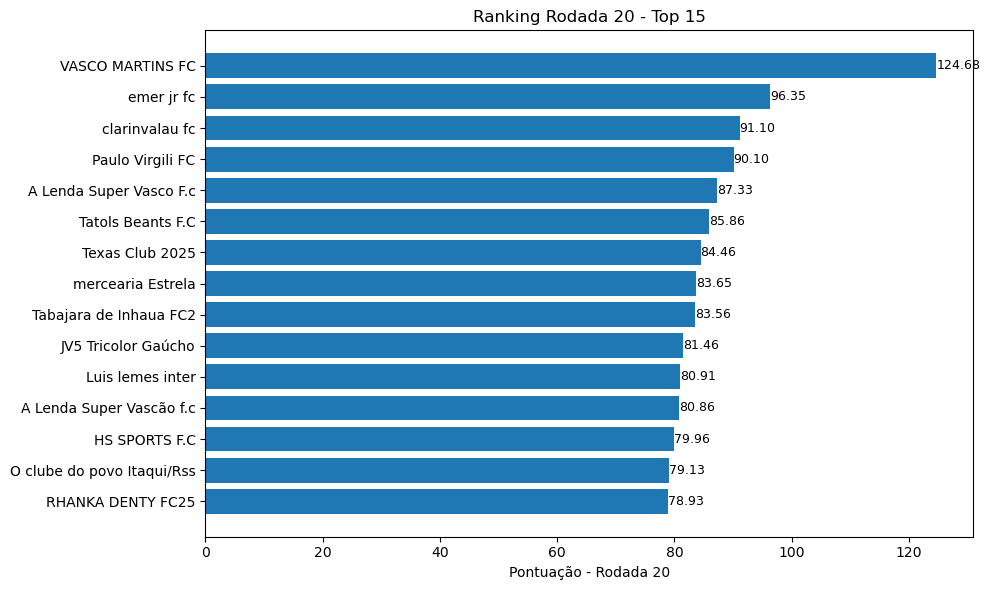

In [33]:
import matplotlib.pyplot as plt

# --- 1) Encontrar a última rodada com dados ---
df_base = df_pontuacoes.drop(index='Lider_Rodada', errors='ignore').copy()

rodada_cols = []
for c in df_base.columns:
    m = re.fullmatch(r"Rodada\s+(\d+)", str(c))
    if m:
        n = int(m.group(1))
        if pd.to_numeric(df_base[c], errors="coerce").notna().any():
            rodada_cols.append((n, c))
if not rodada_cols:
    raise ValueError("Nenhuma coluna 'Rodada N' com dados encontrada.")

rodada_num_ultimo, col_ultima = max(rodada_cols, key=lambda x: x[0])
print(f"➡️ Plotando ranking de {col_ultima}")

# --- 2) Montar ranking (pontuação + posição) ---
serie = pd.to_numeric(df_base[col_ultima], errors="coerce").fillna(0.0)
df_ranking_rodada = (
    serie.sort_values(ascending=False)
         .rename("Pontuação").to_frame()
)
df_ranking_rodada["Posição"] = (
    df_ranking_rodada["Pontuação"].rank(method="min", ascending=False).astype(int)
)
df_ranking_rodada = (
    df_ranking_rodada.reset_index()
                     .rename(columns={"index": "Time"})
                     .sort_values(["Posição", "Time"], ascending=[True, True])
                     .reset_index(drop=True)
)

# --- 3) Plot (Top N em barras horizontais) ---
top_n = 15  # ajuste se quiser mais/menos times
data_plot = df_ranking_rodada.iloc[:top_n].copy()
data_plot = data_plot.sort_values("Pontuação")  # para o barh ficar do menor -> maior

plt.figure(figsize=(10, 6))
plt.barh(data_plot["Time"], data_plot["Pontuação"])  # sem definir cores
plt.xlabel(f"Pontuação - {col_ultima}")
plt.title(f"Ranking {col_ultima} - Top {top_n}")
# Anotar valores nas barras
for y, v in enumerate(data_plot["Pontuação"].to_numpy()):
    plt.text(v, y, f"{v:.2f}", va="center", ha="left", fontsize=9)
plt.tight_layout()
plt.show()

# (Opcional) Exportar o ranking usado no gráfico
# df_ranking_rodada.to_excel("Ranking_ultima_rodada.xlsx", index=False)
# df_ranking_rodada.to_csv("Ranking_ultima_rodada.csv", index=False, encoding="utf-8-sig")
